# Capacitance Estimation with Multinomial Regression


In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Dataset

Our dataset is a wire capacitance table on 20nm process node. 
It is a 2D array of wire-length, wire-width, temperature and wire-capacitance.
We'll use wire length and wire capacitance as our dataset for linear regression example.


|Wire-length | Wire-width  | Wire-Thickness | Capacitance
|------------|-------------|----------------|-------------
| (meters)   | (meters)    | (meters)       | (Farads)
| 2.663e-06  | 9.713e-08   | 9.874e-10      | 5.201e-16 
| 4.626e-06  | 1.054e-07   | 9.325e-10      | 1.023e-15
| 4.210e-06  | 8.348e-08   | 1.097e-09      | 6.546e-16 
| 4.654e-06  | 1.010e-07   | 1.021e-09      | 9.115e-16 
| 5.085e-06  | 1.175e-07   | 9.807e-10      | 1.183e-15 
| 5.002e-06  | 6.509e-08   | 9.565e-10      | 7.140e-16 
| 4.970e-06  | 8.999e-08   | 9.861e-10      | 9.091e-16 
| 6.115e-06  | 1.030e-07   | 1.046e-09      | 1.191e-15
| 6.483e-06  | 1.095e-07   | 9.673e-10      | 1.435e-15 
| 5.444e-06  | 1.336e-07   | 9.952e-10      | 1.402e-15 



In [2]:
#Load dataset
datafile = os.path.join('..','data','cap.tbl.gz')
dataset = np.loadtxt(datafile, dtype=np.float32, ndmin=2)


data_mean = np.mean(dataset, axis=0)
data_std  = np.std(dataset, axis=0)
print('dataset mean vector:', data_mean)
print('dataset std  vector:', data_std)

# reduce the dataset for quick experiments
#dataset = dataset[0:300,:]

dataset mean vector: [  5.00974966e-06   1.00001934e-07   9.99881733e-10   9.92978206e-16]
dataset std  vector: [  1.03122318e-06   2.04158273e-08   4.01410294e-11   2.75874052e-16]


# Visualize dataset
Visualizing your dataset in single dimension gives you clues to come up with a good cost function.

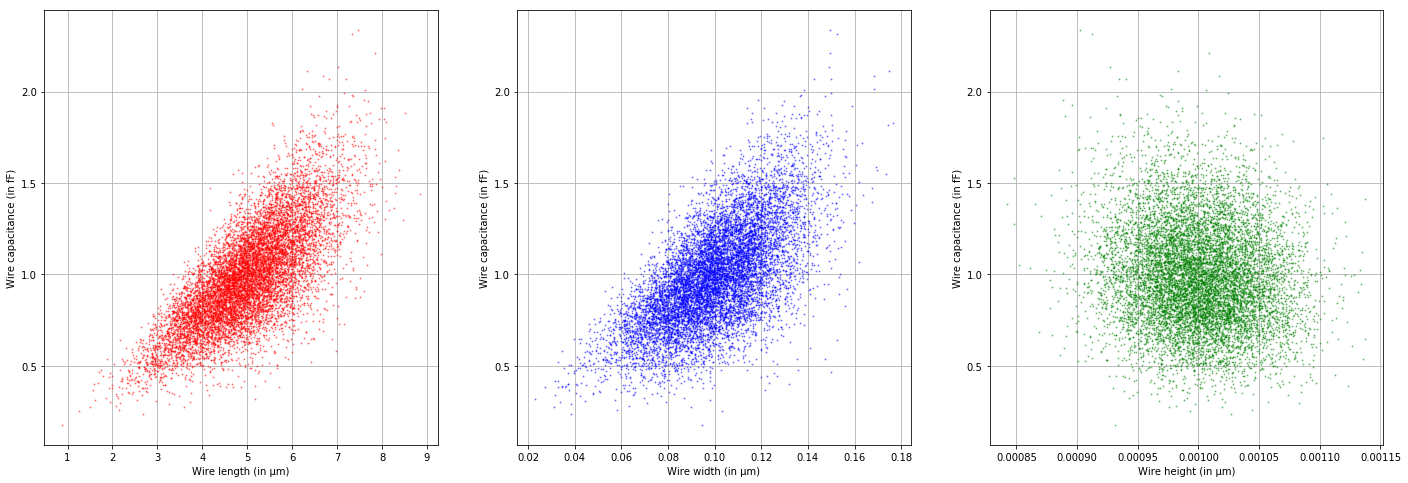

In [3]:
plt.figure(figsize=(24,8))

plt.subplot(1, 3, 1)
plt.plot(dataset[:,0]*1e6, dataset[:,3]*1e15, 'ro', label='Dataset', marker='o', markersize=1, alpha=0.4)
plt.xlabel('Wire length (in μm)')
plt.ylabel('Wire capacitance (in fF)')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(dataset[:,1]*1e6, dataset[:,3]*1e15, 'bo', label='Dataset', marker='o', markersize=1, alpha=0.4)
plt.xlabel('Wire width (in μm)')
plt.ylabel('Wire capacitance (in fF)')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(dataset[:,2]*1e6, dataset[:,3]*1e15, 'go', label='Dataset', marker='o', markersize=1, alpha=0.4)
plt.xlabel('Wire height (in μm)')
plt.ylabel('Wire capacitance (in fF)')
plt.grid()

plt.show()

Note in the graphs above, first graph (length vs cap) appears to show linear relationship, second graph (width vs cap) shows mild square relationship and thid graph (height vs cap) has good amount of noise.

## Normalization
Since our length/width/height values are small (ranging from 0.1nm to 10μm) and capacitance values are even smaller (ranging from 0.2 Ff to over 2fF), it is **very important** normalize the dataset right after loading.

In [4]:
# normalize the dataset between 0 and 1.
def normalize(d, mean, std):
    return (d - mean) / std

def denormalize(d, mean, std):
    return (d * std) + mean

dataset = normalize(dataset, data_mean, data_std)
np.random.shuffle(dataset)

print('dataset feature min vector = ', np.min(dataset, axis=0))
print('dataset feature max vector = ', np.max(dataset, axis=0))

dataset feature min vector =  [-4.00523233 -3.77583194 -3.92020106 -2.95800662]
dataset feature max vector =  [ 3.72197676  3.74172163  3.43206382  4.87722921]


## Divide the dataset
into training dataset and validation dataset

In [5]:
# training dataset percentage is 80%
def divide_dataset(dataset):
    train_pct = 0.8; 
    # divide dataset into training and validation set
    train_index = int(dataset.shape[0]*train_pct)
    t_X = dataset[:train_index,0:3]
    t_Y = dataset[:train_index,3]
    v_X = dataset[train_index:,0:3]
    v_Y = dataset[train_index:,3]
    
    return t_X, t_Y, v_X, v_Y

train_X, train_Y, valid_X, valid_Y = divide_dataset(dataset)
n_samples = train_X.shape[0]

## Declare Graph Variables

Place to declare plave holders and variables for compute graph

In [6]:
# tf Graph Input
X1 = tf.placeholder("float")
X2 = tf.placeholder("float")
X3 = tf.placeholder("float")
Y = tf.placeholder("float")

# Set model weights, W1= 0.74099 W2= 0.64598 W3= 0.132965 W4= -0.134999 b= 0.000667305
W1  = tf.Variable(0.0, name="weight1")
W2  = tf.Variable(0.0, name="weight2")
W3  = tf.Variable(0.0, name="weight3")
W4  = tf.Variable(0.0, name="weight4")
b   = tf.Variable(0.0, name="bias")


## Compute Graph
Construct a multivariate polynomial model

In [7]:
predicted = W1*X1 + W2*X2 + W3*X1*X2 + W4*X3 + b

# Hyper parameters

In [8]:
# Hyper parameters
learning_rate = 1
training_epochs = 1000
display_step = 50

## Cost function and Optimizer

In [9]:
# Mean squared error
cost = tf.reduce_sum((predicted-Y)*(predicted-Y))/(2*n_samples)

# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

## Train the Model

In [10]:
# Prepare data
tX1 = train_X[:,0]
tX2 = train_X[:,1]
tX3 = train_X[:,2]
vX1 = valid_X[:,0]
vX2 = valid_X[:,1]
vX3 = valid_X[:,2]

In [11]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(training_epochs):
        sess.run(optimizer, feed_dict={X1:tX1, X2:tX2, X3:tX3, Y:train_Y})

        #Display logs per epoch step
        if (epoch+1) % display_step == 0:
            c = sess.run(cost, feed_dict={X1:tX1, X2:tX2, X3:tX3, Y:train_Y})
            print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), "W1=", sess.run(W1), "W2=", sess.run(W2), "W3=", sess.run(W3), "W4=", sess.run(W4), "b=", sess.run(b))

    print( "Optimization Finished!" )
                   
    # Record the mode before closing the session
    Weight1  = sess.run(W1)
    Weight2  = sess.run(W2)
    Weight3  = sess.run(W3)
    Weight4  = sess.run(W4)
    Bias     = sess.run(b)

    # Find cost on training and validation dataset.
    training_cost = sess.run(cost, feed_dict={X1:tX1, X2:tX2, X3:tX3, Y:train_Y})
    print ("Training   cost (mean sq. error) =",training_cost, "W1=", sess.run(W1), "W2=", sess.run(W2), "W3=", sess.run(W3), "W4=", sess.run(W4), "b=", sess.run(b))
    validation_cost = sess.run(cost, feed_dict={X1:vX1, X2:vX2, X3:vX3, Y:valid_Y})
    print ("Validation cost (mean sq. error) =",validation_cost, '\n')

Epoch: 0050 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0100 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0150 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0200 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0250 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0300 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0350 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0400 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0450 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0500 cost= 0.000765592 W1= 0.741044 W2= 0.645822 W3= 0.133474 W4= -0.135148 b= 0.000753159
Epoch: 0550 cost= 0.

# Denormalize


In [12]:
# Formulate your trained model as a matrix before denormalization
def PolyModel(x1, x2, x3):
    # W1*X1 + W2*X2 + W3*X1*X2 + W4*X3 + b
    return  Weight1*x1 + Weight2*x2 + Weight3*x1*x2 + Weight4*x3 + Bias

fX = PolyModel(tX1, tX2, tX3)

# Formulate your trained model as a matrix
trained_model = denormalize(fX, data_mean[3], data_std[3])

# De normalize dataset
train_X, train_Y, valid_X, valid_Y = divide_dataset(denormalize(dataset, data_mean, data_std))

# separate variables for graphical display
tX1 = train_X[:,0]
tX2 = train_X[:,1]
tX3 = train_X[:,2]
vX1 = valid_X[:,0]
vX2 = valid_X[:,1]
vX3 = valid_X[:,2]

# Plot Model with Dataset

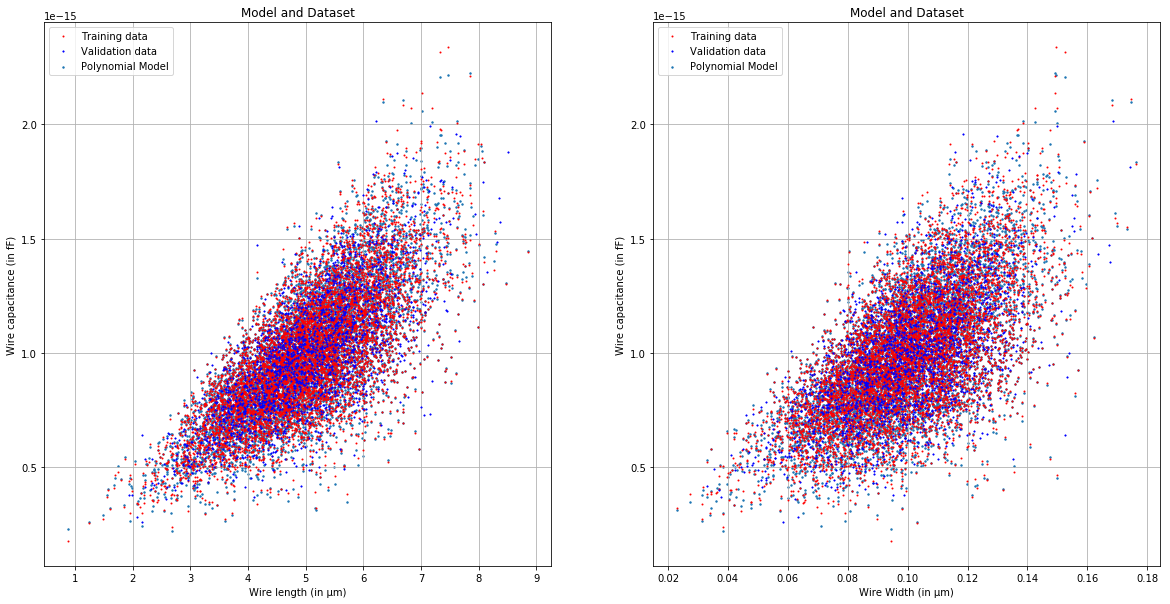

In [13]:
#Graphic display
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.plot(tX1*1e6, train_Y, 'ro', label='Training data', marker='o', markersize=1)
plt.plot(vX1*1e6, valid_Y, 'bo', label='Validation data', marker='D', markersize=1)
plt.scatter(train_X[:,0]*1e6, trained_model, label='Polynomial Model', s=2)
plt.title('Model and Dataset')
plt.xlabel('Wire length (in μm)')
plt.ylabel('Wire capacitance (in fF)')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Model and Dataset')
plt.xlabel('Wire Width (in μm)')
plt.ylabel('Wire capacitance (in fF)')
plt.grid()
plt.plot(tX2*1e6, train_Y, 'ro', label='Training data', marker='o', markersize=1)
plt.plot(vX2*1e6, valid_Y, 'bo', label='Validation data', marker='D', markersize=1)
plt.scatter(train_X[:,1]*1e6, trained_model, label='Polynomial Model', s=2)
plt.legend()

plt.show()

# Predict Capacitance Values 

In [14]:
def predictCapacitance(length, width, thickness):
    l = normalize(length,    data_mean[0], data_std[0])
    w = normalize(width,     data_mean[1], data_std[1])
    t = normalize(thickness, data_mean[2], data_std[2])
    return denormalize(PolyModel(l,w,t), data_mean[3], data_std[3])

# convert values shows in the table at the top into quads.
cap_tbl = [ [2.663e-06 , 9.713e-08 , 9.874e-10 , 5.201e-16],
            [4.626e-06 , 1.054e-07 , 9.325e-10 , 1.023e-15],
            [4.210e-06 , 8.348e-08 , 1.097e-09 , 6.546e-16],
            [4.654e-06 , 1.010e-07 , 1.021e-09 , 9.115e-16],
            [5.085e-06 , 1.175e-07 , 9.807e-10 , 1.183e-15],
            [5.002e-06 , 6.509e-08 , 9.565e-10 , 7.140e-16],
            [4.970e-06 , 8.999e-08 , 9.861e-10 , 9.091e-16],
            [6.115e-06 , 1.030e-07 , 1.046e-09 , 1.191e-15],
            [6.483e-06 , 1.095e-07 , 9.673e-10 , 1.435e-15],
            [5.444e-06 , 1.336e-07 , 9.952e-10 , 1.402e-15] ]

for quad in cap_tbl:
    predicted_capacitance = predictCapacitance(quad[0], quad[1], quad[2])
    print( "Wire length = ", "{:.3g}".format(quad[0]), ", Predicted Capacitance = ", 
          "{:.3g}".format(predicted_capacitance), ", Actual Capacitance =", "{:.3g}".format(quad[3]),
         ". Diff=", "{:.3g}".format(quad[3]-predicted_capacitance))

Wire length =  2.66e-06 , Predicted Capacitance =  5.26e-16 , Actual Capacitance = 5.2e-16 . Diff= -6.17e-18
Wire length =  4.63e-06 , Predicted Capacitance =  1.02e-15 , Actual Capacitance = 1.02e-15 . Diff= -1.8e-19
Wire length =  4.21e-06 , Predicted Capacitance =  6.23e-16 , Actual Capacitance = 6.55e-16 . Diff= 3.12e-17
Wire length =  4.65e-06 , Predicted Capacitance =  9.11e-16 , Actual Capacitance = 9.11e-16 . Diff= 3.66e-19
Wire length =  5.08e-06 , Predicted Capacitance =  1.18e-15 , Actual Capacitance = 1.18e-15 . Diff= 2.07e-18
Wire length =  5e-06 , Predicted Capacitance =  7.28e-16 , Actual Capacitance = 7.14e-16 . Diff= -1.37e-17
Wire length =  4.97e-06 , Predicted Capacitance =  9.11e-16 , Actual Capacitance = 9.09e-16 . Diff= -2.33e-18
Wire length =  6.11e-06 , Predicted Capacitance =  1.2e-15 , Actual Capacitance = 1.19e-15 . Diff= -1.04e-17
Wire length =  6.48e-06 , Predicted Capacitance =  1.42e-15 , Actual Capacitance = 1.44e-15 . Diff= 1.21e-17
Wire length =  5.44e

# Error Distribution

In [15]:
def sampleError(sampleData, goldData):
    sampleData = predictCapacitance(sampleData[:,0], sampleData[:,1], sampleData[:,2])
    error = (goldData-sampleData)/goldData
    return error

training_Error   = sampleError(train_X, train_Y)
validation_Error = sampleError(valid_X, valid_Y)

print('Training   error mean=', np.mean(training_Error),   ' and distribution=', np.std(training_Error))
print('Validation error mean=', np.mean(validation_Error), ' and distribution=', np.std(validation_Error))

Training   error mean= 9.13292e-05  and distribution= 0.0141867
Validation error mean= 0.000378974  and distribution= 0.014376


# Plot Error

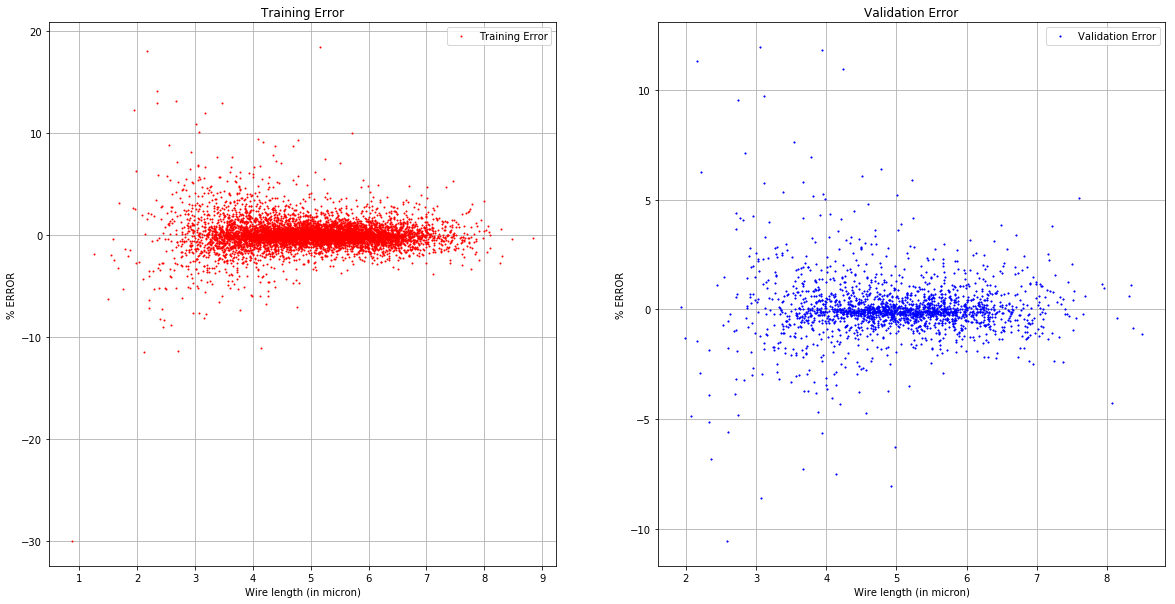

In [16]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(train_X[:,0]*1e6, 100*training_Error, 'ro', label='Training Error', marker='o', markersize=1)
plt.title('Training Error')
plt.xlabel('Wire length (in micron)')
plt.ylabel('% ERROR')
#plt.ylim(-40, 80)
plt.legend()


plt.subplot(1, 2, 2)
plt.grid()
plt.plot(valid_X[:,0]*1e6, 100*validation_Error, 'bo', label='Validation Error', marker='D', markersize=1)
plt.title('Validation Error')
plt.xlabel('Wire length (in micron)')
plt.ylabel('% ERROR')
#plt.ylim(-40, 80)
plt.legend()

plt.show()

# 4D Scatter Plots
Plot 4D scatter plots for training and validation with polnomial model as a surface. 
Surface predicts the points for data. All the data points are supposed to be on the
model surface for a perfect model.
Color of the points represents 4th dimension. 


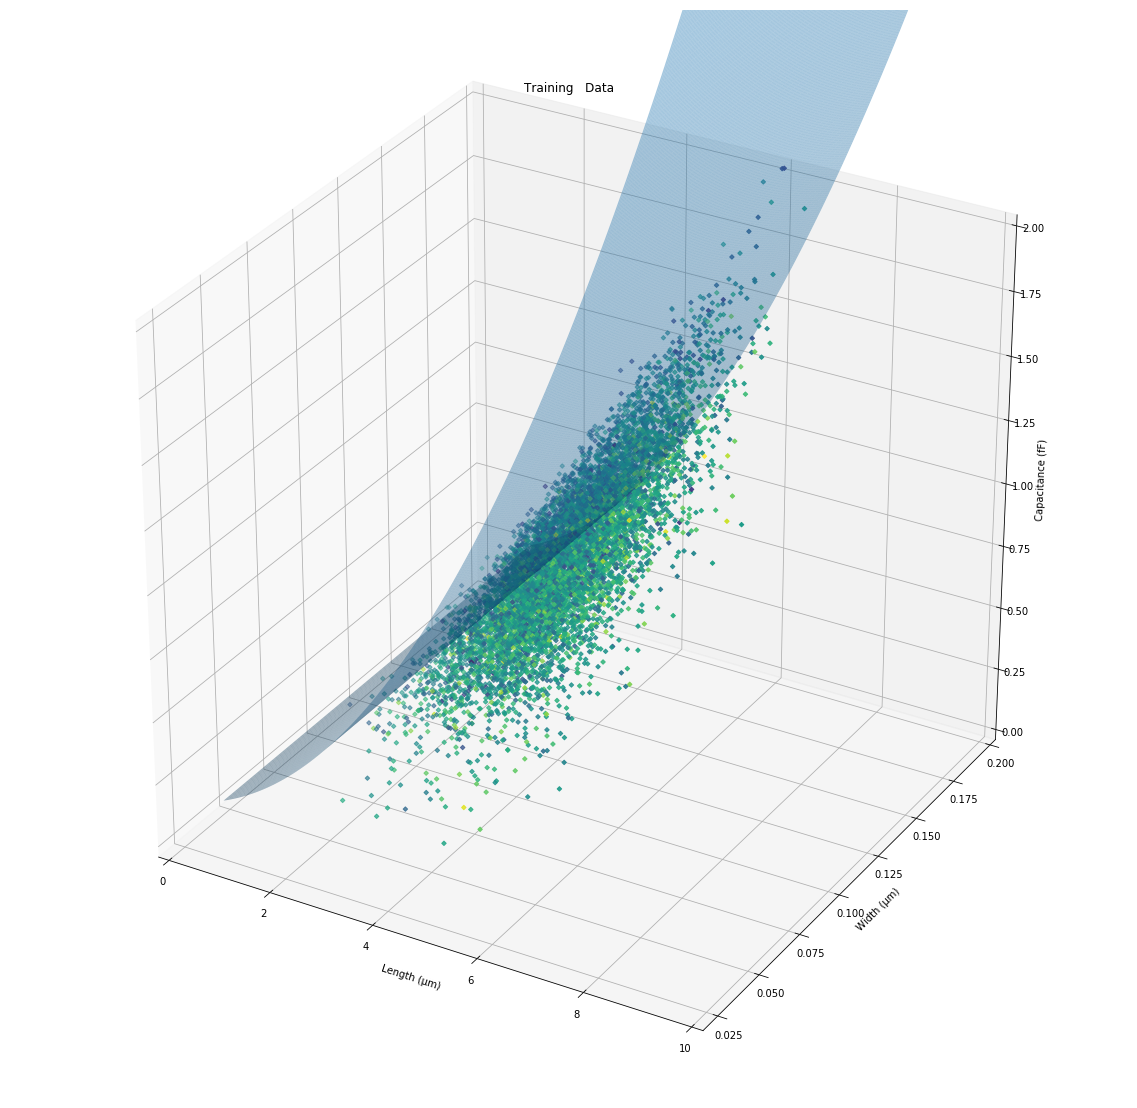

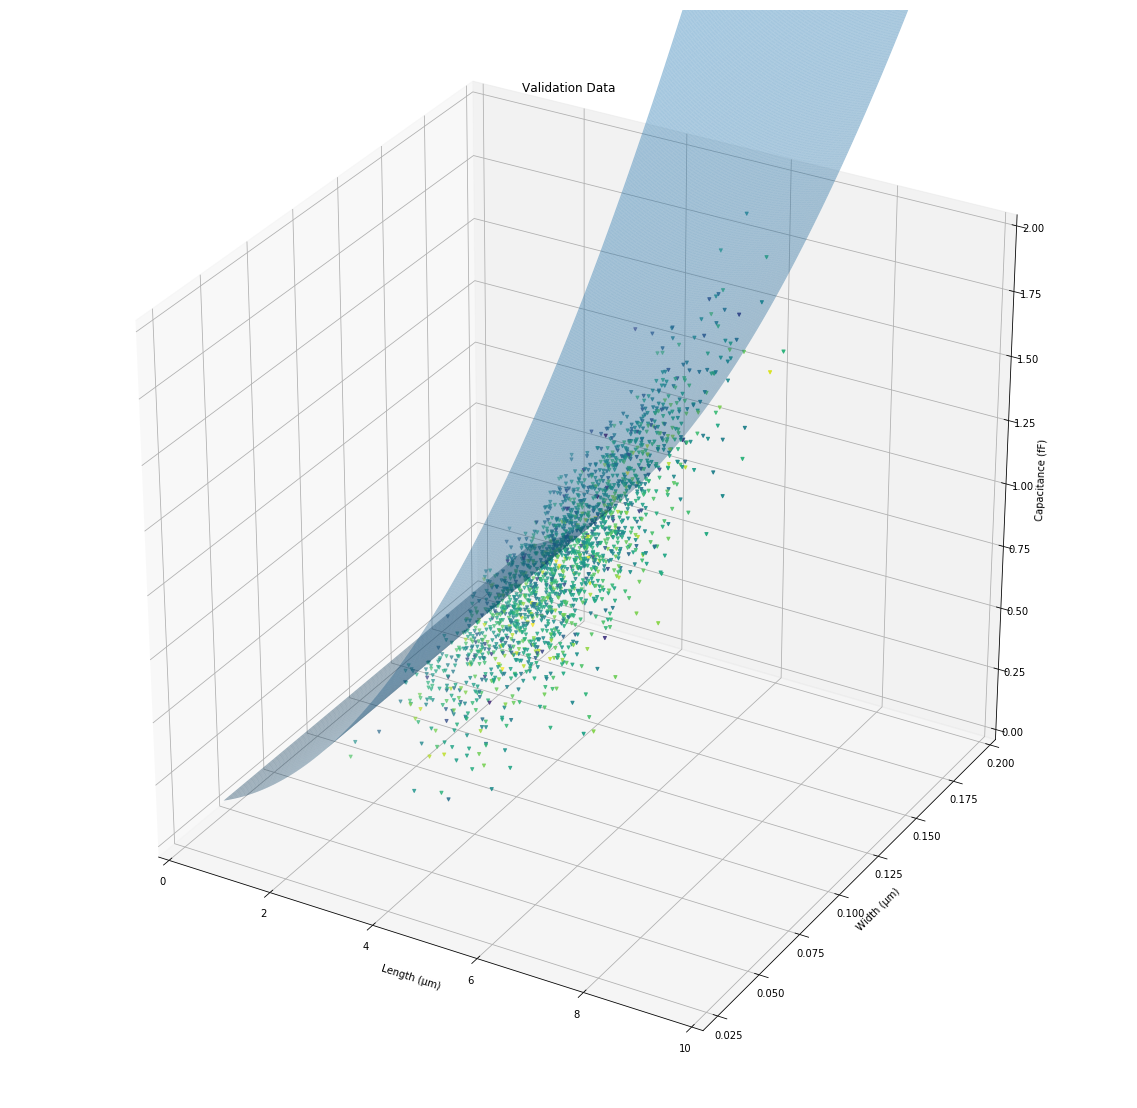

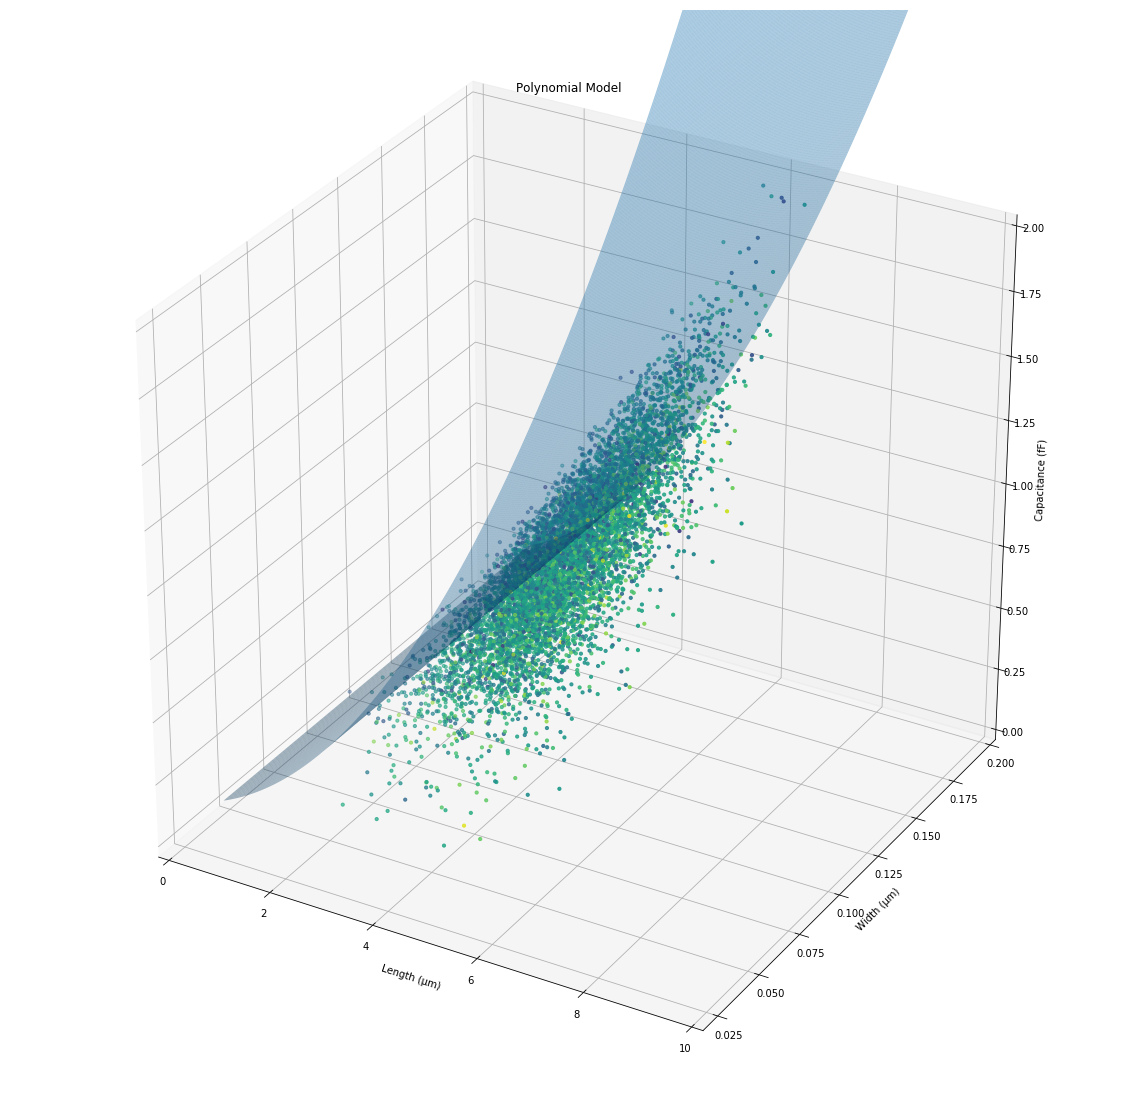

In [17]:
# 4D plot. Here height is represented as color temperature in 
# the 3D plot of length/width as x/y axis and capacitance as Z axis.

from mpl_toolkits.mplot3d import Axes3D

def fourDPlot(t, X, Y, Z, c, m):
    fig = plt.figure(figsize=(20,20))

    ax = fig.gca(projection='3d')

    ax.scatter(X, Y, Z, c=c, marker=m, s=10)

    ax.set_title(t)
    ax.set_xlabel('Length (μm)')
    ax.set_ylabel('Width (μm)')
    ax.set_zlabel('Capacitance (fF)')
    ax.set_xlim(0, 10)
    ax.set_ylim(2e-2, 2e-1)
    ax.set_zlim(0, 2)
    
    # Draw poly model on top of data.
    length_range = np.arange(1,10,0.05)
    width_range  = np.arange(0.02, 0.2, 0.001)
    lgrid, wgrid = np.meshgrid(length_range, width_range)
    sorted_model = np.zeros(length_range.shape)
    height_range = np.arange(0.00085, 0.00115, 1e-6 )
    i=0
    for x1, x2, x3 in zip(length_range, width_range, height_range):
        model_value = PolyModel(normalize(x1*1e-6, data_mean[0], data_std[0]), 
                                normalize(x2*1e-6, data_mean[1], data_std[1]), 
                                normalize(x3*1e-6, data_mean[1], data_std[1]))
        sorted_model[i] = denormalize(model_value, data_mean[3], data_std[3])*1e15
        i=i+1

    surf = ax.plot_surface(lgrid, wgrid, sorted_model, rstride=1, cstride=1, alpha=0.4)

    plt.show()
    
fourDPlot('Training   Data', tX1*1e6, tX2*1e6, train_Y*1e15,        tX3, 'D')
fourDPlot('Validation Data', vX1*1e6, vX2*1e6, valid_Y*1e15,        vX3, 'v')
fourDPlot('Polynomial Model', tX1*1e6, tX2*1e6, trained_model*1e15, tX3, 'o')
